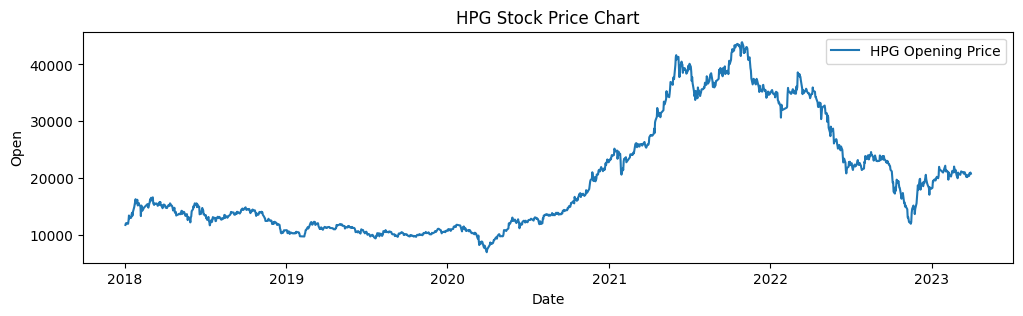

In [ ]:
import pandas as pd
import os
os.chdir('/content/')
actual_data = pd.read_excel('./HPG_model.xlsx')
actual_data.set_index('Date', inplace=True)

# Time vs Price line plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,3))
sns.lineplot(data=actual_data,x = "Date", y = "Open", label = 'HPG Opening Price')
plt.title('HPG Stock Price Chart')
plt.show()

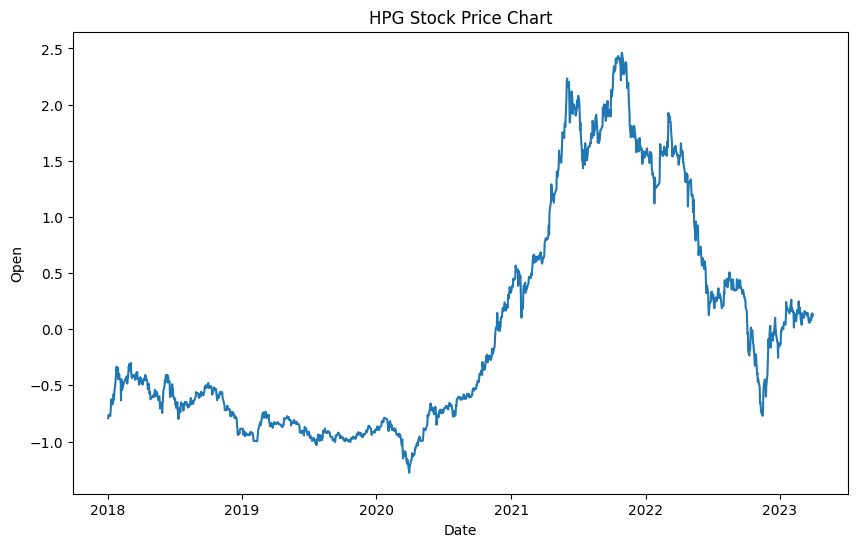

In [ ]:
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
actual_data[['Price','High','Low','Vol']] = xscaler.fit_transform(actual_data[['Price','High','Low','Vol']] )
yscaler = StandardScaler()
actual_data[['Open']] = yscaler.fit_transform(actual_data[['Open']] )
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,6))
sns.lineplot(data=actual_data, x = 'Date', y = 'Open')
plt.title('HPG Stock Price Chart')
plt.show()

In [ ]:
actual_data

,Open,Price,High,Low,Vol
Date,,,,,
2018-01-02,-0.792468,-0.773179,-0.790055,-0.786382,-0.550295
2018-01-03,-0.764495,-0.775721,-0.771233,-0.764386,-0.359723
2018-01-04,-0.769562,-0.760368,-0.773736,-0.756676,-0.409080
2018-01-05,-0.761860,-0.765553,-0.772434,-0.755443,-0.666831
2018-01-08,-0.772096,-0.727120,-0.746004,-0.759246,-0.655863
...,...,...,...,...,...
2023-03-27,0.080182,0.122468,0.100560,0.105108,-0.239073
2023-03-28,0.130858,0.112301,0.110572,0.141084,-0.783368
2023-03-29,0.110588,0.122468,0.120583,0.141084,-0.398797


In [ ]:
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from sklearn.model_selection import train_test_split

class SequenceData(Dataset):
    def __init__(self,
                 dataframe:pd.DataFrame,
                 sequence_length:int,
                 label_column:str
                 ):
        self.__data = deepcopy(dataframe)
        self.__data.sort_index(inplace=True) # index must be the time column
        self.sequence_length = sequence_length
        self.label_column = label_column
        self.cols_to_scale = [i for i in self.__data.columns if i!=self.label_column]
        self._prepare_for_loader()

        # self._scale()
    def _prepare_for_loader(self):
        time_slice = self.sequence_length
        self.index_to_gather =[list(range(i, i+time_slice+1)) for i in range(len(actual_data)-time_slice)]
    def __len__(self):
        return len(self.index_to_gather)
    def __getitem__(self, idx:int):
        sequence_indexs = self.index_to_gather[idx]
        x_index, y_index = sequence_indexs[:-1], sequence_indexs[-1]
        return {'features':self.__data[self.cols_to_scale].iloc[x_index].values,
                'y': self.__data[self.label_column].iloc[y_index],
                'Date': self.__data.index[y_index].timestamp()}

dataset = SequenceData(actual_data, 50, 'Open') # time step=50: use 50 previous time to predict the current
len(dataset)

1258

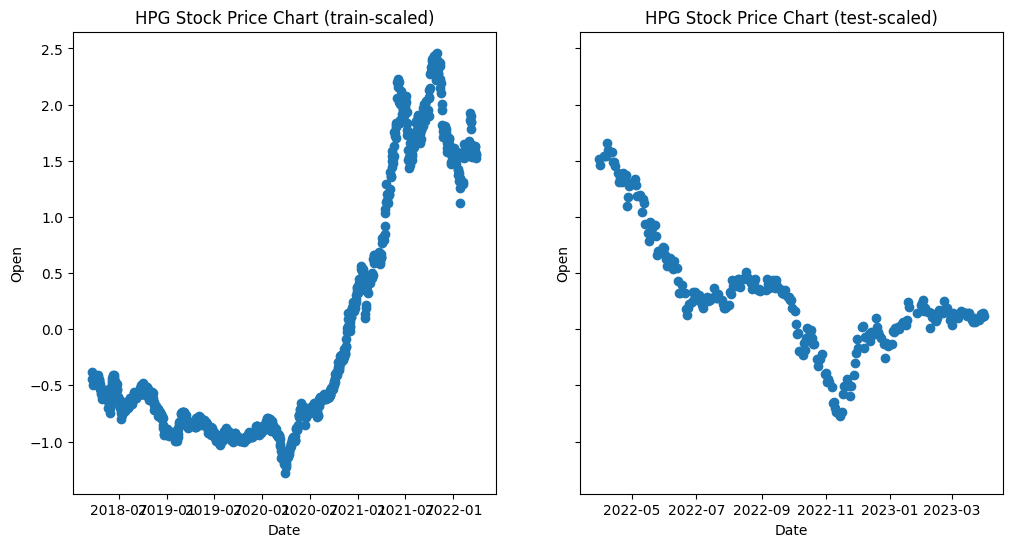

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt

dataset = SequenceData(actual_data, 50, 'Open')

test_size = 0.2
test_size = int((test_size)*len(dataset))

train_indices, test_indices = list(range(len(dataset)))[:-test_size], \
  list(range(len(dataset)))[-test_size:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_dataloader = DataLoader(dataset, batch_size=4,sampler=train_sampler,
                        num_workers=0)
date = []
open = []
input_dim = None
for sample in train_dataloader:
    date.extend(pd.to_datetime(sample['Date'].tolist(), unit='s'))
    open.extend(sample['y'].tolist())
    input_dim = sample['features'].shape[-1]
train_df = pd.DataFrame({
    'Date':date,
    'Open':open
})
train_df.set_index('Date', inplace=True)

test_dataloader = DataLoader(dataset, batch_size=32,sampler=test_sampler,
                        num_workers=0)

date = []
open = []
for sample in test_dataloader:
    date.extend(pd.to_datetime(sample['Date'].tolist(), unit='s'))
    open.extend(sample['y'].tolist())
test_df = pd.DataFrame({
    'Date':date,
    'Open':open
})
test_df.set_index('Date', inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,6))

ax1.scatter(train_df.index, train_df['Open'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Open')
ax1.set_title('HPG Stock Price Chart (train-scaled)')

ax2.scatter(test_df.index, test_df['Open'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Open')
ax2.set_title('HPG Stock Price Chart (test-scaled)')

plt.show()

In [ ]:
from torch import nn
import torch.optim as optim

# LSTM + Linear + Sigmoid + Linear
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size, bias=True)
        self.activate = nn.Sigmoid()
        self.final_fc = nn.Linear(hidden_size, 1, bias=True)

    def forward(self, x, h_0=None, c_0=None):
        if h_0 is not None and c_0 is not None:
            out, (h1, c1) = self.lstm(x, (h_0, c_0))
        else:
            out, (h1, c1) = self.lstm(x,)
        out = self.fc(out[:, -1, :])
        out = self.activate(out)
        out = self.final_fc(out).view(-1)
        return out, (h1, c1)

In [ ]:
# Train the model
num_epochs = 20
batch_size = 32

model = LSTMRegressor(input_dim, 100)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_dataloader = DataLoader(dataset, batch_size=batch_size,sampler=train_sampler,
                        num_workers=0)
test_dataloader = DataLoader(dataset, batch_size=batch_size,sampler=test_sampler,
                        num_workers=0)

for epoch in range(num_epochs):
    for sample in train_dataloader:
        # Get batch inputs and targets
        inputs = sample['features'].float()
        targets = sample['y'].float()

        # Forward pass
        outputs, (_, _) = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 0.0109
Epoch [2/20], Loss: 0.0020
Epoch [3/20], Loss: 0.0007
Epoch [4/20], Loss: 0.0004
Epoch [5/20], Loss: 0.0037
Epoch [6/20], Loss: 0.0009
Epoch [7/20], Loss: 0.0044
Epoch [8/20], Loss: 0.0023
Epoch [9/20], Loss: 0.0021
Epoch [10/20], Loss: 0.0006
Epoch [11/20], Loss: 0.0020
Epoch [12/20], Loss: 0.0009
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0014
Epoch [15/20], Loss: 0.0010
Epoch [16/20], Loss: 0.0010
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0010
Epoch [19/20], Loss: 0.0009
Epoch [20/20], Loss: 0.0009


In [ ]:
print(model)

LSTMRegressor(
  (lstm): LSTM(4, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=100, bias=True)
  (activate): Sigmoid()
  (final_fc): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
# Evaluate the model
from sklearn.metrics import r2_score
import torch
model.eval()
y_true = []
y_pred = []
date = []
with torch.no_grad():
    mse_cummulative_loss = 0
    for sample in test_dataloader:
        # Get batch inputs and targets
        inputs = sample['features'].float()
        extpected = sample['y'].float()

        # Forward pass
        outputs, (_, _) = model(inputs)
        loss = criterion(outputs, extpected)
        y_true.extend(extpected.tolist())
        y_pred.extend(outputs.tolist())
        date.extend(sample['Date'].tolist())
        mse_cummulative_loss+=loss

y_true = yscaler.inverse_transform([y_true]).reshape(-1)
y_pred = yscaler.inverse_transform([y_pred]).reshape(-1)

# calculate MAE between observed and predicted values
import math
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
r2 = r2_score(y_true, y_pred)
mae_01 = mean_absolute_error(y_true, y_pred)
mape_01 = mean_absolute_percentage_error(y_true, y_pred)
MSE = np.square(np.subtract(y_true,y_pred)).mean()
rmse_01 = math.sqrt(MSE)
print("R-square:", r2)
print("MAE:", mae_01)
print("MAPE:", mape_01)
print("RMSE:", rmse_01)

R-square: 0.9944873389446882
MAE: 285.3646596690302
MAPE: 0.013903811169414198
RMSE: 367.1662512229104


In [ ]:
output = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'Date': pd.to_datetime(date, unit='s')
})

output.set_index('Date', inplace=True)
output.sort_index(inplace=True)
output.to_csv('HPG_pred.csv', index = False)

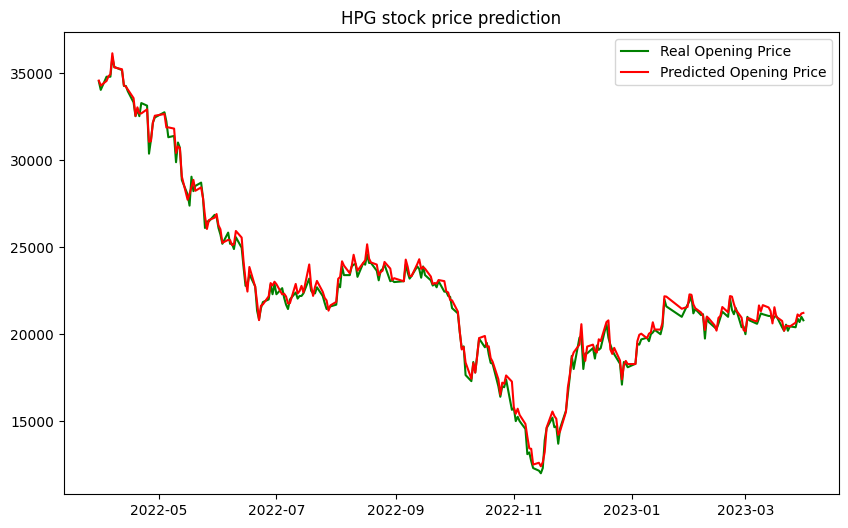

In [ ]:
#plot expected vs actual
fig, ax = plt.subplots(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
ax.plot(output['y_true'], color='green', label = 'Real Opening Price')
ax.plot(output['y_pred'], color='red', label = 'Predicted Opening Price')
ax.legend()
plt.title("HPG stock price prediction")
plt.show()